# Проект: классификация

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [ ]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [ ]:
df.info()

In [402]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
pd.isnull(df['balance']).value_counts()[1]

25

### Задание 2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['education'].value_counts()

### Задание 3

In [ ]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
type(df['balance'])

In [ ]:
df['new_balance'] = df['balance'].apply(lambda x: str(x).replace('$', ''))
df['new_balance'] = df['new_balance'] .apply(lambda x: str(x).replace(' ', ''))
df['new_balance'] = df['new_balance'] .apply(lambda x: float(str(x).replace(',00', '')))
df['new_balance'].mean()
df = df.drop(columns = "balance")

### Задание 4

In [ ]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['new_balance'] = df['new_balance'].fillna(df['new_balance'].median())
df['new_balance'].mean()

### Задание 5

In [408]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [409]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: str(df['job'].mode()[0]) if x == 'unknown' else str(x)) 
df['education'] = df['education'].apply(lambda x: str(df['education'].mode()[0]) if x == 'unknown' else x) 


In [410]:
df['education'].value_counts()

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [411]:
df[(df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0])]['new_balance'].mean()

1598.8829787234042

### Задание 6

In [456]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    cleaned.reset_index(inplace=True)
    return outliers, cleaned

_,cleaned_df = outliers_iqr(df, 'new_balance')
cleaned_df.shape

(10105, 18)

## Часть 2:  Разведывательный анализ

### Задание 1

In [486]:
cleaned_df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [485]:

fig=px.pie(
    data_frame=cleaned_df['deposit'],
    names = 'deposit',
    title='Соотношение клиентов открывших и неоткрыших депозит',
    color = 'deposit',
    color_discrete_map={'Male':'blue','Female':'pink'},
    width=500,
    height=500
)
fig.show()


### Задания 2 и 3

In [494]:
cleaned_df = cleaned_df.drop(columns = "index")


In [502]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned_df.describe()

,age,day,duration,campaign,pdays,previous,new_balance
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,15.590302,368.742603,2.517170,51.319644,0.816230,807.653538
std,11.734931,8.441510,346.651524,2.707159,109.644179,2.243795,994.151966
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,-2049.000000
25%,32.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,95.000000
50%,38.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,445.000000
75%,48.000000,22.000000,490.000000,3.000000,2.000000,1.000000,1227.000000
max,95.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,4063.000000


In [500]:

cleaned_df[cleaned_df['deposit'] == 'yes'].describe()

,age,day,duration,campaign,pdays,previous,new_balance
count,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000
mean,41.203162,15.073489,539.568896,2.136296,68.776757,1.157018,953.071566
std,13.291117,8.503427,394.408498,1.921040,119.854999,2.542359,1040.543075
min,18.000000,1.000000,8.000000,1.000000,-1.000000,0.000000,-1944.000000
25%,31.000000,8.000000,245.000000,1.000000,-1.000000,0.000000,163.000000
50%,38.000000,15.000000,429.000000,2.000000,-1.000000,0.000000,569.000000
75%,49.000000,21.000000,727.000000,2.000000,98.000000,1.000000,1495.000000
max,95.000000,31.000000,3881.000000,32.000000,854.000000,58.000000,4060.000000


In [501]:
cleaned_df[cleaned_df['deposit'] == 'no'].describe()

,age,day,duration,campaign,pdays,previous,new_balance
count,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000,5424.00000
mean,40.629978,16.036320,221.316740,2.845870,36.253872,0.522124,682.15542
std,10.196686,8.362851,206.688801,3.199471,97.527835,1.901471,934.37434
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,-2049.00000
25%,33.000000,8.000000,93.000000,1.000000,-1.000000,0.000000,46.00000
50%,39.000000,16.000000,163.000000,2.000000,-1.000000,0.000000,342.00000
75%,48.000000,22.000000,278.000000,3.000000,-1.000000,0.000000,992.00000
max,89.000000,31.000000,3284.000000,43.000000,826.000000,41.000000,4063.00000


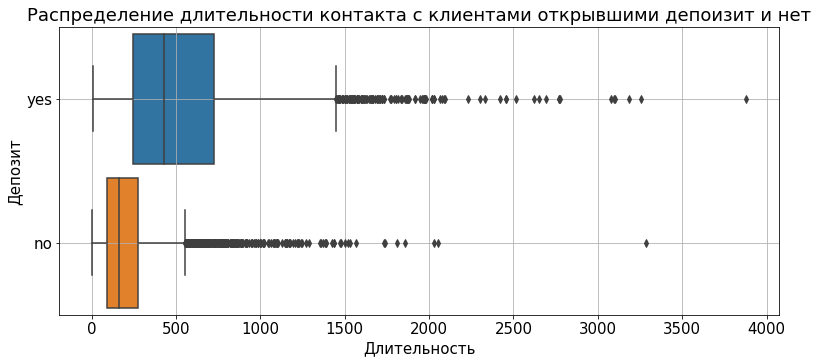

In [506]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='duration',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение длительности контакта с клиентами открывшими депоизит и нет');
boxplot.set_xlabel('Длительность');
boxplot.set_ylabel('Депозит');
boxplot.grid()

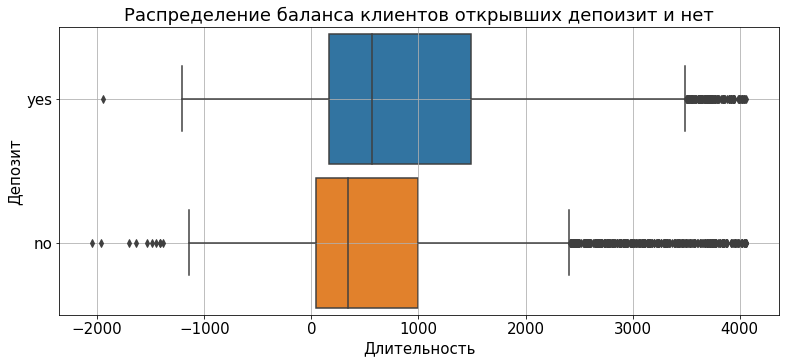

In [511]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='new_balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса клиентов открывших депоизит и нет');
boxplot.set_xlabel('Длительность');
boxplot.set_ylabel('Депозит');
boxplot.grid()

### Итерпритация описательных статистик колличественных переменных.
##### Были получены статистики для колличественных переменных всего набора данных, а также отдельно для открывших депозит и нет. 
##### Про признак возраста на первый взгяд сказать нечего. Средний возраст практически не отличается для групп и всего набора данных, неадекватных выбрасов не наблюдается, максимальный возраст 95 лет хоть и является очень высоким, но теортически аномальным не является. В дальнейшем можно будет отнести большой возраст к бывросам по методу трех сигм. Признак day необходимо преобразовать в дату. Duration признак длительности контакта. Видна значительная разница в длительнсти контакта банка с клиентами открывшими депозит и нет. На ящиках с усами эта разница наглядно представлена, так же видны выбросы. По признаку колличества контакотов можно предположить, что с увеличением значения признака вероятность открытия депозита падает. Признак кооличества пропущенных дней с момента последней маркетинговой компании на данный момент ни о чем не говорит, так как имеет очень большое стандартное отклонение, сделать какие то выводы невозможно. По колличеству контактов до текущей компании видно, что люди имвешие хотя бы один контакт с банком ранее охотнее открывают депозит. По текущему балансу видно, что люди с большим колличеством денег охотнее не много открывают депозит, распределение визаулизировано.

### Задания 4 и 5

####  По полученной визуализации видно, что за исключением голубых воротничков, которые чаще отказываются от открытия депозита, в остальном вероятность открытия не зависит от работы. 

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly import tools
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for c in cat:
    fig = px.sunburst(
    cleaned_df, 
    path=[c, 'deposit'],
    width=750,
    height=550,
    title='Влияние признака ' + c + ' положения на вероятность открытия депозита',

    )
    fig.update_traces(textinfo="label+percent entry")
    fig.show()

    


#### Из полученных визуализаций категориальных признаков видно, что доли открывших и неоткрывших депозит мало зависит от значений признака за исключением некоторых: 
#### 1. Если клиент участововал в предыдущей маркетинговой комапнии, то он скорее всего откроет депозит
#### 2. В мае клиенты в три раза реже открывают депозит
#### 3. Если мы не знаем, как мы связазлись с клиентиом, скорее всего он не откроет депозит. Это нужно исследовать глубже
#### 4. Люди с кредитом на жилье в 2 раза реже открывают депозит
#### 5. Люди не в браке чаще открывают депозит 

### Задание 6

In [607]:
cleaned_df.groupby('poutcome')['deposit'].value_counts(normalize=True, sort=False)

poutcome  deposit
failure   no         0.506763
          yes        0.493237
other     no         0.449064
          yes        0.550936
success   no         0.088889
          yes        0.911111
unknown   no         0.602642
          yes        0.397358
Name: deposit, dtype: float64

### Задание 7

'may'

In [623]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month = cleaned_df['month'].values
for i in range(len(cleaned_df['month'].values)):
    print(month[i], cleaned_df[cleaned_df['month'] == month[i]]['deposit'].value_counts(normalize=True, sort=False)[0])


may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.32136033626289645
may 0.3213603362

In [614]:
cleaned_df[cleaned_df['month'] == 'may']['deposit'].value_counts(normalize=True, sort=F)

no     0.67864
yes    0.32136
Name: deposit, dtype: float64

### Задание 8

In [418]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [419]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [420]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [421]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [422]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [423]:
# преобразуйте уровни образования

### Задания 2 и 3

In [424]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [425]:
# создайте дамми-переменные

### Задания 5 и 6

In [426]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [427]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [428]:
# рассчитайте необходимые показатели

### Задание 9

In [429]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [430]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [431]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [432]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [433]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [434]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [435]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [436]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [437]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [438]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna